<a href="https://colab.research.google.com/github/bofeng2268/qm2/blob/main/analysis_plot_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [342]:
!pip install seaborn
!pip install matplotlib
!pip install esda
!pip install Pillow
!pip install geopandas libpysal mgwr

In [343]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from scipy.stats import sem
import statistics
import seaborn as sns
from IPython.display import display, Math, Latex, display_latex
import plotly.express as px
import pylab
import pandas as pd
import numpy as np

In [344]:
#from example
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from statsmodels.formula.api import ols
from esda.moran import Moran
from libpysal.weights import Queen
import geopandas as gpd
import requests
import json
from prettytable import PrettyTable
from sklearn.preprocessing import StandardScaler
from statsmodels.iolib.summary2 import summary_col
import libpysal as ps
import geopandas as gpd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

# Merging and Cleaning Data

In [345]:
#FILE PATHS
csv_file_path = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/TS038-2021-3-filtered-2024-01-01T16-28-10Z.csv'
topojson_file_path = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/topo_lad.json'
local_authorities_file_path = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/download6923730533685635445.csv'


In [346]:
#prepare the dataset for total disabled people density by regions
#link source:
total=pd.read_csv('https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/TS038-2021-3-filtered-2024-01-01T16-28-10Z.csv')
eng_disability_data = total[total['Lower tier local authorities Code'].str.startswith('E')]
filtered_disability_data = eng_disability_data[eng_disability_data['Disability (5 categories) Code'].isin([1, 2])]
disabled = filtered_disability_data.groupby('Lower tier local authorities')['Observation'].sum().reset_index()
disabled['Lower tier local authorities'] = disabled['Lower tier local authorities'].apply(lambda string: string.strip()) #all values e togli spazi davanti e dietro



In [347]:
print(disabled)

            Lower tier local authorities  Observation
0                                   Adur        12577
1                              Allerdale        19205
2                           Amber Valley        25066
3                                   Arun        32481
4                               Ashfield        27809
5                                Ashford        22655
6                                Babergh        16160
7                   Barking and Dagenham        28993
8                                 Barnet        49679
9                               Barnsley        53916
10                     Barrow-in-Furness        14652
11                              Basildon        31380
12                 Basingstoke and Deane        27778
13                             Bassetlaw        24022
14          Bath and North East Somerset        31778
15                               Bedford        28727
16                                Bexley        36083
17                          

Renaming Lower Tier Local Authorities

Bristol --> Bristol, City of

Herefordshire --> Herefordshire, County of

Kingston upon Hull --> Kingston upon Hull, City of

North Northamptonshire --> East Northamptonshire

West Northamptonshire --> South Northamptonshire

In [348]:

rename_map = {
    'Bristol': 'Bristol, City of',
    'Herefordshire': 'Herefordshire, County of',
    'Kingston upon Hull': 'Kingston upon Hull, City of',
    'North Northamptonshire': 'East Northamptonshire',
    'West Northamptonshire': 'South Northamptonshire'
}

disabled['Lower tier local authorities'] = disabled['Lower tier local authorities'].map(rename_map).fillna(disabled['Lower tier local authorities'])
print(disabled)

            Lower tier local authorities  Observation
0                                   Adur        12577
1                              Allerdale        19205
2                           Amber Valley        25066
3                                   Arun        32481
4                               Ashfield        27809
5                                Ashford        22655
6                                Babergh        16160
7                   Barking and Dagenham        28993
8                                 Barnet        49679
9                               Barnsley        53916
10                     Barrow-in-Furness        14652
11                              Basildon        31380
12                 Basingstoke and Deane        27778
13                             Bassetlaw        24022
14          Bath and North East Somerset        31778
15                               Bedford        28727
16                                Bexley        36083
17                          

In [349]:
#prepare the blue badged population by regions
blue_badge = pd.read_csv('https://raw.githubusercontent.com/bofeng2268/qm2/main/BlueBadge/Blue_badges_held.csv', delimiter=';')
blue_badges_narrowed =  blue_badge[['Local Authority', 'Total valid Blue Badges held by organisations and individuals']].copy()
filtered_blue_badges = blue_badges_narrowed[~blue_badges_narrowed['Local Authority'].str.contains('All')].copy()
filtered_blue_badges['Local Authority'] = filtered_blue_badges['Local Authority'].apply(lambda string: string.strip()) #all values e togli spazi davanti e dietro


filtered_blue_badges.reset_index(drop=True, inplace=True)

filtered_blue_badges


,Local Authority,Total valid Blue Badges held by organisations and individuals
0,County Durham,27.884
1,Darlington,5.945
2,Hartlepool,5.530
3,Middlesbrough,6.546
4,Northumberland,16.242
5,Redcar and Cleveland,7.680
6,Stockton-on-Tees,12.810
7,Tyne and Wear,52.714
8,Gateshead,8.951
9,Newcastle upon Tyne,9.221


In [350]:
#TIMES 1000

filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'], errors='coerce')



# Now, multiply by 1000 and convert to integer
filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'] = filtered_blue_badges['Total valid Blue Badges held by organisations and individuals'].apply(lambda x : int(1000*x))

filtered_blue_badges

,Local Authority,Total valid Blue Badges held by organisations and individuals
0,County Durham,27884
1,Darlington,5945
2,Hartlepool,5530
3,Middlesbrough,6546
4,Northumberland,16242
5,Redcar and Cleveland,7680
6,Stockton-on-Tees,12810
7,Tyne and Wear,52714
8,Gateshead,8951
9,Newcastle upon Tyne,9221


In [351]:
#RENAME

In [352]:
rename_map = {
    'North Northamptonshire': 'East Northamptonshire',
    'West Northamptonshire': 'South Northamptonshire',
    'Cambridgeshire': 'East Cambridgeshire',
    'Hampshire': 'East Hampshire',
    'Derbyshire': 'Derbyshire Dales',
    'Lancashire': 'West Lancashire',
    'Lincolnshire': 'Lincoln',
    'Somerset': 'South Somerset',
    'Surrey': 'Surrey Heath',
    'Warwickshire': 'North Warwickshire',
    'Leicestershire': 'North West Leicestershire'}

filtered_blue_badges['Local Authority'] = filtered_blue_badges['Local Authority'].map(rename_map).fillna(filtered_blue_badges['Local Authority'])
filtered_blue_badges

pd.set_option('display.max_rows', None)
print(filtered_blue_badges)


                         Local Authority  \
0                          County Durham   
1                             Darlington   
2                             Hartlepool   
3                          Middlesbrough   
4                         Northumberland   
5                   Redcar and Cleveland   
6                       Stockton-on-Tees   
7                          Tyne and Wear   
8                              Gateshead   
9                    Newcastle upon Tyne   
10                        North Tyneside   
11                        South Tyneside   
12                            Sunderland   
13                 Blackburn with Darwen   
14                             Blackpool   
15                         Cheshire East   
16             Cheshire West and Chester   
17                                Halton   
18                            Warrington   
19                               Cumbria   
20                    Greater Manchester   
21                              

In [353]:
# Function to do the division and create new local authorities
# guarda che ci sono nbel data set degli spazi tra
filtered_blue_badges['Local Authority'] = filtered_blue_badges['Local Authority'].apply(lambda string: string.strip()) #all values e togli spazi davanti e dietro
def divide_and_create_local_authorities(df, original_la, new_local_authorities, division_factor):
    if original_la in df['Local Authority'].values:
        original_value = df[df['Local Authority'] == original_la]['Total valid Blue Badges held by organisations and individuals'].iloc[0]
        divided_value = original_value / division_factor

        # Creating new rows for the new local authorities
        for la in new_local_authorities:
            new_row = {'Local Authority': la, 'Total valid Blue Badges held by organisations and individuals': divided_value}
            df = df.append(new_row, ignore_index=True)

        # Remove the original local authority row
        df = df[df['Local Authority'] != original_la]

    return df


# Step 1 - Essex
new_local_authorities_essex = ['Braintree', 'Castle Point', 'Chelmsford', 'Colchester', 'Harlow', 'Maldon', 'Rochford', 'Uttlesford']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Essex', new_local_authorities_essex, 8)


filtered_blue_badges


# Step 2 (Worcestershire
new_local_authorities_worcestershire = ['Bromsgrove', 'Malvern Hills', 'Redditch', 'Worcester', 'Wychavon', 'Wyre Forest']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Worcestershire', new_local_authorities_worcestershire, 6)

filtered_blue_badges

# Hertfordshire aggiungere spazio (AGGIUNGERE NELLA ANALISI CHE BISOGNAVA METTERE LO SPAZIO)
new_local_authorities_hertfordshire = ['North Hertfordshire', 'South Hertfordshire']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Hertfordshire', new_local_authorities_hertfordshire, 2)

# Norfolk
new_local_authorities_norfolk = ["King's Lynn and West Norfolk", 'South Norfolk', 'North Norfolk']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Norfolk', new_local_authorities_norfolk, 3)

# Oxfordshire
new_local_authorities_oxfordshire = ['South Oxfordshire', 'West Oxfordshire']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Oxfordshire', new_local_authorities_oxfordshire, 2)

# Devon
new_local_authorities_devon = ['East Devon', 'Mid Devon', 'West Devon', 'North Devon']
filtered_blue_badges = divide_and_create_local_authorities(filtered_blue_badges, 'Devon', new_local_authorities_devon, 4)

filtered_blue_badges

#By doing this we manage to have all datapoints from Blue Badges dataset to be merged with the mirrorred datapoints from the other datasets. Since Blue Badges is the one with less datapoints

<ipython-input-353-777562427819>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-353-777562427819>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-353-777562427819>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-353-777562427819>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-353-777562427819>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-353-777562427819>:12: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future versi

,Local Authority,Total valid Blue Badges held by organisations and individuals
0,County Durham,27884.000000
1,Darlington,5945.000000
2,Hartlepool,5530.000000
3,Middlesbrough,6546.000000
4,Northumberland,16242.000000
5,Redcar and Cleveland,7680.000000
6,Stockton-on-Tees,12810.000000
7,Tyne and Wear,52714.000000
8,Gateshead,8951.000000
9,Newcastle upon Tyne,9221.000000


In [354]:
#merge the two datasets
merged_data = pd.merge(filtered_blue_badges, disabled, left_on='Local Authority', right_on='Lower tier local authorities', how='inner')


# Convert columns to numeric
merged_data['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric(merged_data['Total valid Blue Badges held by organisations and individuals'])
merged_data['Observation'] = pd.to_numeric(merged_data['Observation'])
merged_data

,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation
0,County Durham,27884.000000,County Durham,119790
1,Darlington,5945.000000,Darlington,21104
2,Hartlepool,5530.000000,Hartlepool,21145
3,Middlesbrough,6546.000000,Middlesbrough,29520
4,Northumberland,16242.000000,Northumberland,67190
5,Redcar and Cleveland,7680.000000,Redcar and Cleveland,30483
6,Stockton-on-Tees,12810.000000,Stockton-on-Tees,39052
7,Gateshead,8951.000000,Gateshead,42548
8,Newcastle upon Tyne,9221.000000,Newcastle upon Tyne,56961
9,North Tyneside,8324.000000,North Tyneside,41748


In [355]:
#Transport Reliant People
# Convert columns to numeric
merged_data['Total valid Blue Badges held by organisations and individuals'] = pd.to_numeric( merged_data['Total valid Blue Badges held by organisations and individuals'])
merged_data['Observation'] = pd.to_numeric( merged_data['Observation'])

# Create the new column by subtracting the two columns
merged_data['Transport reliant people with a disability estimate'] =  merged_data['Observation'] -  merged_data['Total valid Blue Badges held by organisations and individuals']
merged_data



,Local Authority,Total valid Blue Badges held by organisations and individuals,Lower tier local authorities,Observation,Transport reliant people with a disability estimate
0,County Durham,27884.000000,County Durham,119790,91906.000000
1,Darlington,5945.000000,Darlington,21104,15159.000000
2,Hartlepool,5530.000000,Hartlepool,21145,15615.000000
3,Middlesbrough,6546.000000,Middlesbrough,29520,22974.000000
4,Northumberland,16242.000000,Northumberland,67190,50948.000000
5,Redcar and Cleveland,7680.000000,Redcar and Cleveland,30483,22803.000000
6,Stockton-on-Tees,12810.000000,Stockton-on-Tees,39052,26242.000000
7,Gateshead,8951.000000,Gateshead,42548,33597.000000
8,Newcastle upon Tyne,9221.000000,Newcastle upon Tyne,56961,47740.000000
9,North Tyneside,8324.000000,North Tyneside,41748,33424.000000


In [356]:
#GET RID OF CITY OF LONDON - INACCURATE DATA POINT (provide Justification in analysis)
merged_data = merged_data[merged_data['Local Authority'] != 'City of London']
merged_data = merged_data.drop(['Lower tier local authorities'],axis=1)
merged_data.rename(columns={'Observation': 'Disable_population'}, inplace=True)
merged_data.rename(columns={'Total valid Blue Badges held by organisations and individuals': 'Blue_Badges_population'}, inplace=True)
merged_data.rename(columns={'Transport reliant people with a disability estimate': 'Transport_reliant_population'}, inplace=True)


merged_data

,Local Authority,Blue_Badges_population,Disable_population,Transport_reliant_population
0,County Durham,27884.000000,119790,91906.000000
1,Darlington,5945.000000,21104,15159.000000
2,Hartlepool,5530.000000,21145,15615.000000
3,Middlesbrough,6546.000000,29520,22974.000000
4,Northumberland,16242.000000,67190,50948.000000
5,Redcar and Cleveland,7680.000000,30483,22803.000000
6,Stockton-on-Tees,12810.000000,39052,26242.000000
7,Gateshead,8951.000000,42548,33597.000000
8,Newcastle upon Tyne,9221.000000,56961,47740.000000
9,North Tyneside,8324.000000,41748,33424.000000


#Summary Statistics

In [357]:
summary=merged_data.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary=summary.T #.T transposes the table (rows become columns and vice versa)
summary

,count,mean,std,min,25%,50%,75%,max
Blue_Badges_population,160.0,13067.33,9857.08,1768.0,7439.50,10346.75,14580.00,62975.0
Disable_population,160.0,42081.15,26105.32,294.0,24880.25,36891.00,53519.25,198064.0
Transport_reliant_population,160.0,29013.82,25062.61,-40706.0,18271.50,27365.50,40360.75,158004.0


In [358]:
# Setup the PrettyTable
table = PrettyTable()
table.field_names = ["Variable", "Mean", "St. Dev.", "Min", "25%", "50%", "75%", "Max"]
table.title = "Summary Statistics"

# Add data to the table
for row in summary.iterrows():
    table.add_row([row[0], row[1]["mean"], row[1]["std"], row[1]["min"], row[1]["25%"], row[1]["50%"], row[1]["75%"], row[1]["max"]])

# Print the table
print(table)

+-----------------------------------------------------------------------------------------------------------+
|                                             Summary Statistics                                            |
+------------------------------+----------+----------+----------+----------+----------+----------+----------+
|           Variable           |   Mean   | St. Dev. |   Min    |   25%    |   50%    |   75%    |   Max    |
+------------------------------+----------+----------+----------+----------+----------+----------+----------+
|    Blue_Badges_population    | 13067.33 | 9857.08  |  1768.0  |  7439.5  | 10346.75 | 14580.0  | 62975.0  |
|      Disable_population      | 42081.15 | 26105.32 |  294.0   | 24880.25 | 36891.0  | 53519.25 | 198064.0 |
| Transport_reliant_population | 29013.82 | 25062.61 | -40706.0 | 18271.5  | 27365.5  | 40360.75 | 158004.0 |
+------------------------------+----------+----------+----------+----------+----------+----------+----------+


# Outliers

In [359]:

def filter_outliers(var):
    Q1 = var.quantile(0.25)  # Calculate the first quartile
    Q3 = var.quantile(0.75)  # Calculate the third quartile
    IQR = Q3 - Q1  # Calculate the interquartile range
    LOWBOUND = Q1 - 3*IQR  # Calculate the lower bound
    HIGHBOUND = Q3 + 3*IQR  # Calculate the upper bound

    # Get the indices of the rows that are within the bounds
    valid_indices = var[(var > LOWBOUND) & (var < HIGHBOUND)].index

    # Filter the DataFrame using the valid indices
    filtered = merged_data.loc[valid_indices]

    dropped_observations = len(var) - len(filtered)  # Calculate the number of observations that were dropped
    print('Dropped {} observations'.format(dropped_observations))

    return filtered, valid_indices


In [360]:
merged_data_no_outliers, _ = filter_outliers(merged_data['Blue_Badges_population'])

merged_data_no_outliers, _ = filter_outliers(merged_data_no_outliers['Disable_population'])

merged_data_no_outliers, _ = filter_outliers(merged_data_no_outliers['Transport_reliant_population'])


Dropped 7 observations
Dropped 1 observations
Dropped 0 observations


In [361]:
# Create an instance of PrettyTable
table = PrettyTable()

# Define the column names
table.field_names = ["Variable", "Observations Dropped"]

# Add rows to the table with the data
table.add_row(["Blue_Badges_population", 7])
table.add_row(["Disable_population", 1])
table.add_row(["Transport_reliant_population", 1])


# Print the table
print(table)

+------------------------------+----------------------+
|           Variable           | Observations Dropped |
+------------------------------+----------------------+
|    Blue_Badges_population    |          7           |
|      Disable_population      |          1           |
| Transport_reliant_population |          1           |
+------------------------------+----------------------+


#Box Plots

In [362]:
#Variables
x = merged_data[['Blue_Badges_population']]
y = merged_data[['Disable_population']]
z = merged_data[['Transport_reliant_population']]

In [363]:
# Create the Box Plot
import plotly.express as px

fig = px.box(merged_data, y='Disable_population', title= 'Disabled Population, England 2022')

fig.show()

In [364]:
# Create the Box Plot
import plotly.express as px

fig = px.box(merged_data, y='Blue_Badges_population', title= 'Box Plot of Blue Badges Held per Local Authority, England 2022')

fig.show()

In [365]:
# Create the Box Plot
import plotly.express as px

fig = px.box(merged_data, y='Transport_reliant_population', title= 'Box Plot of Estimate Transport Reliant People with a Disability Population per Local Authority, England 2022')

fig.show()

# Histogram


## Disabled Population

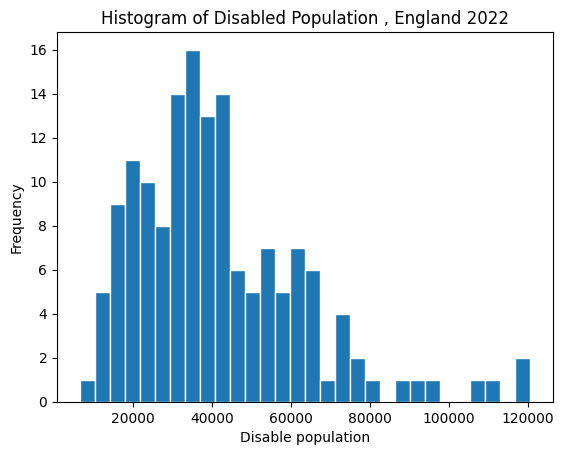

In [366]:
plt.hist(merged_data_no_outliers['Disable_population'], bins=30, edgecolor='white', density=False)

plt.ylabel('Frequency')
plt.xlabel('Disable population') # add a label to the x axis
plt.title("Histogram of Disabled Population , England 2022")
plt.show()

## Transport Reliant Population

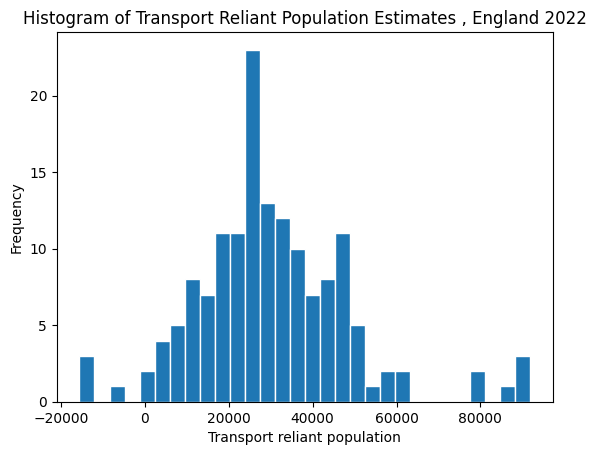

In [367]:
plt.hist(merged_data_no_outliers['Transport_reliant_population'], bins=30, edgecolor='white', density=False)

plt.ylabel('Frequency')
plt.xlabel('Transport reliant population') # add a label to the x axis
plt.title("Histogram of Transport Reliant Population Estimates , England 2022")
plt.show()

## Blue Badges Held

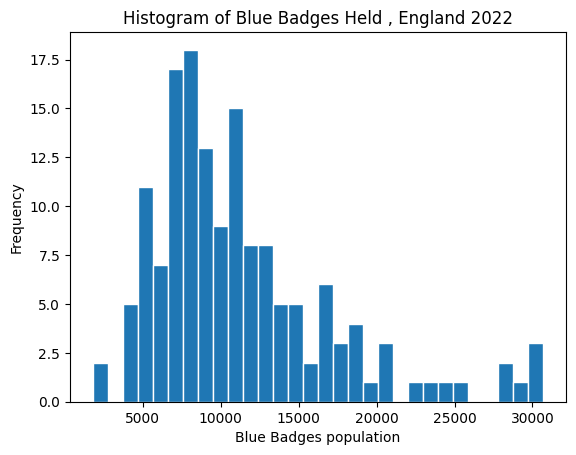

In [368]:
plt.hist(merged_data_no_outliers['Blue_Badges_population'], bins=30, edgecolor='white', density=False)

plt.ylabel('Frequency')
plt.xlabel('Blue Badges population') # add a label to the x axis
plt.title("Histogram of Blue Badges Held , England 2022")
plt.show()

# Simple Regression Analysis

# Transport Reliant Population VS Total Disabled Population per Local Authority

Text(0.5, 1.0, 'Transport Reliant Population VS Total Disabled Population Scatterplot')

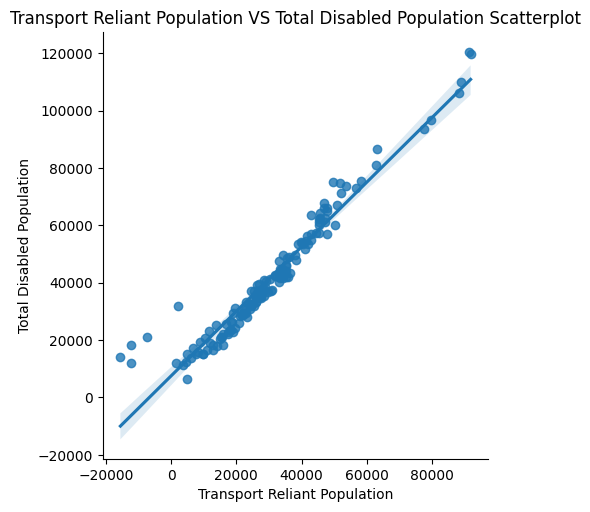

In [369]:
# Generate the scatter plot
sns.lmplot(x='Transport_reliant_population', y='Disable_population', data= merged_data_no_outliers)

plt.xlabel('Transport Reliant Population')
plt.ylabel('Total Disabled Population')

# Display the plot
plt.title("Transport Reliant Population VS Total Disabled Population Scatterplot")

### ❌ LONELINESS or DEPRIVATION FACTOR VS BLUE BADGES HELD (look at the end for the plan of next steps)

# OLS Regression


## New section

### Homoscedasticity test - Breusch-Pagan test

In [370]:
def homoscedasticity_test(lm_results):
    print(lm_results.summary())

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(lm_results.resid, lm_results.model.exog)

    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print("\nBreusch-Pagan test for homoscedasticity:")
    homoscedasticity = False
    for label, value in zip(labels, bp_test):
        print(f"{label}: {value}")
        if label == "F-Test p-value":
            if value > 0.05:
                homoscedasticity = True
    if homoscedasticity:
        print("The regression convey homoscedasticity")
    else:
        print("The regression does not convey homoscedasticity")

Text(87.72222222222221, 0.5, 'Transport Reliant population')

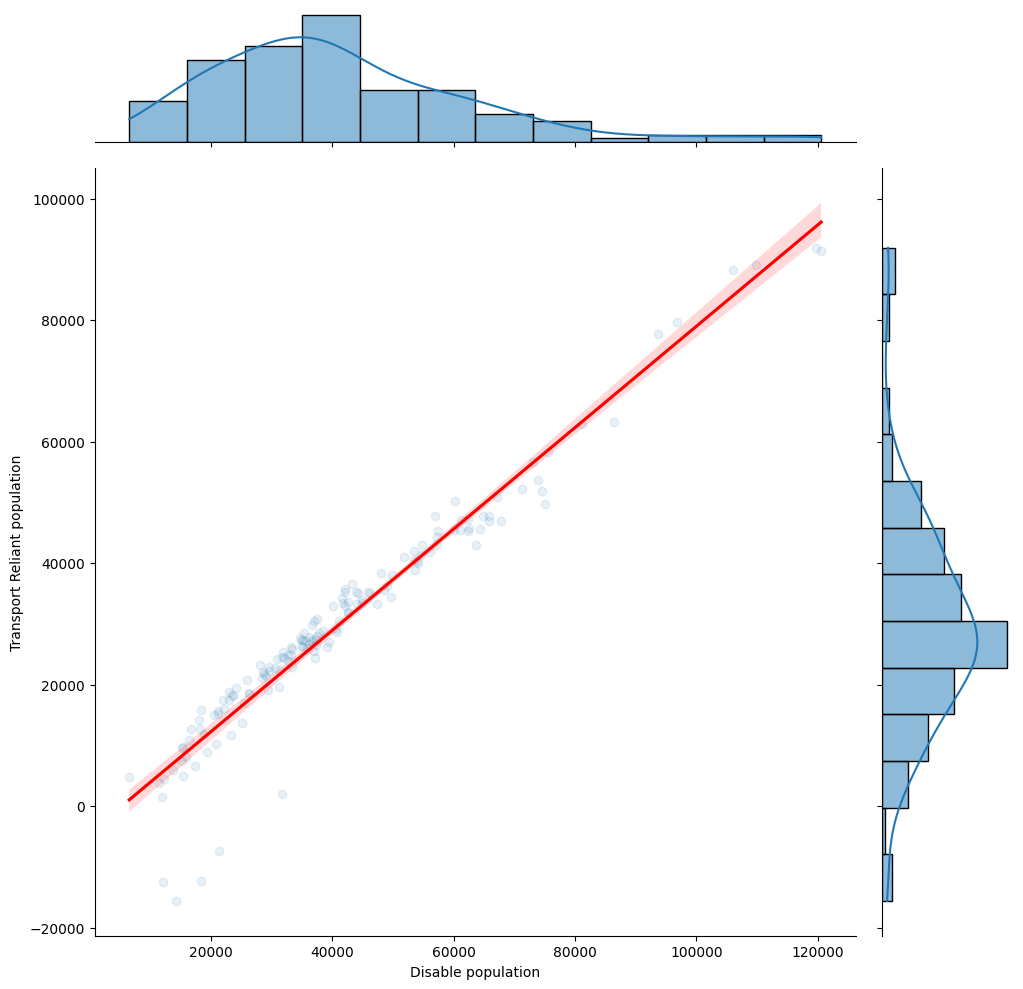

In [371]:
#Homoscedasticity
sns.jointplot(data=merged_data_no_outliers, # plot a scatterplot with a regression line and two histograms
                x='Disable_population', # set the x axis to be the years of schooling
                y='Transport_reliant_population', # set the y axis to be the hourly wage
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Disable population') # add a label to the x axis
plt.ylabel('Transport Reliant population') # add a label to the y axis

In [372]:
from statsmodels.formula.api import ols #the function
from statsmodels.iolib.summary2 import summary_col #to produce a very nice table

model= ols('Transport_reliant_population ~  Disable_population', data=merged_data_no_outliers).fit() # fit the model
print(model.summary()) # print the summary

                                 OLS Regression Results                                 
Dep. Variable:     Transport_reliant_population   R-squared:                       0.937
Model:                                      OLS   Adj. R-squared:                  0.937
Method:                           Least Squares   F-statistic:                     2246.
Date:                          Mon, 15 Jan 2024   Prob (F-statistic):           3.72e-92
Time:                                  16:24:14   Log-Likelihood:                -1498.9
No. Observations:                           152   AIC:                             3002.
Df Residuals:                               150   BIC:                             3008.
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [373]:
import statsmodels.formula.api as smf
from scipy import stats
# Fit a linear regression model and store the results in lm_results_1
lm_results_1 = smf.ols('Transport_reliant_population ~  Disable_population', data=merged_data_no_outliers).fit()

homoscedasticity_test(lm_results_1)

                                 OLS Regression Results                                 
Dep. Variable:     Transport_reliant_population   R-squared:                       0.937
Model:                                      OLS   Adj. R-squared:                  0.937
Method:                           Least Squares   F-statistic:                     2246.
Date:                          Mon, 15 Jan 2024   Prob (F-statistic):           3.72e-92
Time:                                  16:24:14   Log-Likelihood:                -1498.9
No. Observations:                           152   AIC:                             3002.
Df Residuals:                               150   BIC:                             3008.
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

In [374]:
from tabulate import tabulate

# Assign the actual LM test results to variables
lm_statistic = 4.947847597611243
lm_pvalue = 0.02612317219835892

# Define the data for the table
bp_lm_test_data = [
    ["Test Statistic", lm_statistic],
    ["p-value", lm_pvalue]
]

# Create the table using tabulate
bp_lm_test_table = tabulate(bp_lm_test_data, headers=["Test", "Value"], tablefmt="pretty")

# Print the table
print("Results of the Breusch-Pagan LM Test")
print(bp_lm_test_table)

Results of the Breusch-Pagan LM Test
+----------------+---------------------+
|      Test      |        Value        |
+----------------+---------------------+
| Test Statistic |  4.947847597611243  |
|    p-value     | 0.02612317219835892 |
+----------------+---------------------+


# Visualisations

In [375]:
!pip install geopandas
import geopandas as gpd

# Load the GeoJSON file
geojson_url = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/Phenomena/Local%20Authority%20Disability/topo_lad.json'
geo_df = gpd.read_file(geojson_url)
# Check the columns of both dataframes
print(geo_df.columns)
print(merged_data_no_outliers.columns)


Index(['id', 'LAD13CD', 'LAD13CDO', 'LAD13NM', 'LAD13NMW', 'geometry'], dtype='object')
Index(['Local Authority', 'Blue_Badges_population', 'Disable_population',
       'Transport_reliant_population'],
      dtype='object')


In [376]:
geo_df['LAD13NM'] = geo_df['LAD13NM'].astype(str).str.strip()
merged_data_no_outliers['Local Authority'] = merged_data_no_outliers['Local Authority'].astype(str).str.strip()

# Then merge the dataframes on the common key
# 'how' can be 'left', 'right', 'outer', or 'inner' depending on how you want to handle mismatches
merged_geo_data = pd.merge(merged_data_no_outliers, geo_df, left_on='Local Authority', right_on='LAD13NM', how='left')

# Drop the specified columns
merged_geo_data = merged_geo_data.drop(columns=['id', 'LAD13CD', 'LAD13CDO', 'LAD13NM', 'LAD13NMW'])




# Bivariate Choropleth Map

source for colours: https://cran.r-project.org/web/packages/biscale/vignettes/bivariate_palettes.html

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.get_cmap.html


https://github.com/mikhailsirenko/bivariate-choropleth/blob/main/bivariate-choropleth.ipynb.  


In [377]:
Transport_reliant_population = merged_geo_data['Transport_reliant_population']
Disable_population = merged_geo_data['Disable_population']

In [378]:
#convert into geodataframe
if not isinstance(merged_geo_data, gpd.GeoDataFrame):
    merged_geo_data = gpd.GeoDataFrame(merged_geo_data, geometry='geometry')



<ipython-input-379-dd0d397cfa62>:28: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



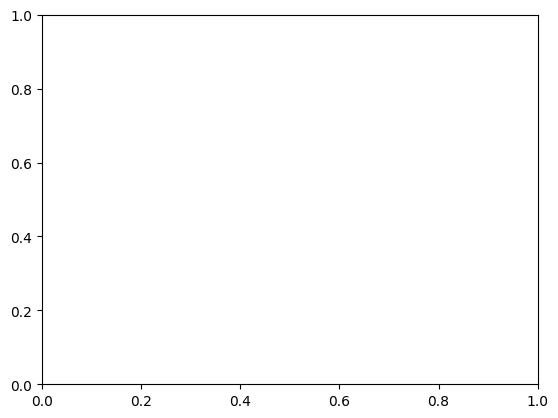

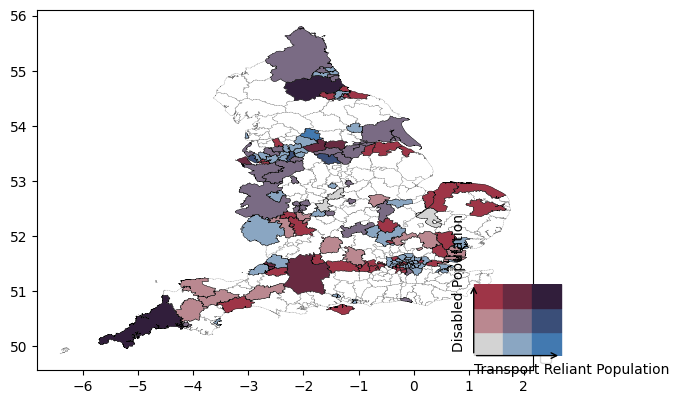

In [379]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
color_sets = {
    'blue-red': [
        # Top row (from left to right)
        '#d3d3d3',  # blue (top left)
        '#ba8890',  # light purple (more blue) (top center)
        '#9e3547',  # purple (top right)

        # Middle row
        '#8aa6c2',  # light blue (middle left)
        '#7a6b84',  # light purple (middle center)
        '#682a41',  # light purple (more blue) (middle right)

        # Bottom row
        '#4279b0',  # light purple (bottom left)
        '#3a4e78',  # light red (bottom center)
        '#311e3b',  # red (bottom right)
    ]
}


# Create figure and axis
fig, ax = plt.subplots(1, 1)

# Define your color set
cmap = plt.cm.get_cmap('RdBu')

# set color
color_set = color_sets['blue-red']


# Normalize the data
transport_norm = ((merged_geo_data['Transport_reliant_population'] - merged_geo_data['Transport_reliant_population'].min()) / (merged_geo_data['Transport_reliant_population'].max() - merged_geo_data['Transport_reliant_population'].min()) * 8).astype(int)
disabled_norm = ((merged_geo_data['Disable_population'] - merged_geo_data['Disable_population'].min()) / (merged_geo_data['Disable_population'].max() - merged_geo_data['Disable_population'].min()) * 8).astype(int)

# Calculate colors for each area
colors = [color_set[max(transport_norm.iloc[i], disabled_norm.iloc[i])] for i in range(len(merged_geo_data))]

# Plot the geometry
merged_geo_data['geometry'].plot(ax=ax, color=colors)

# Add legend
ax2 = fig.add_axes([0.8, 0.15, 0.15, 0.15])
for i in range(3):
    for j in range(3):
        ax2.axvspan(xmin=i/3, xmax=(i+1)/3, ymin=j/3, ymax=(j+1)/3, alpha=1, color=color_set[i*3+j])

ax2.tick_params(axis='both', which='both', length=0)
ax2.axis('off')
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.text(s='Transport Reliant Population', x=0, y=-0.25)
ax2.text(s='Disabled Population', x=-0.25, y=0.1, rotation=90)
legend = ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

geo_df.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.25, linestyle='--')
merged_geo_data.boundary.plot(ax=ax, edgecolor='black', linewidth=0.25)

merged_geo_data.plot(ax=ax, color=colors)


# Show the plot
plt.show()

<ipython-input-380-8ea091a8562e>:40: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



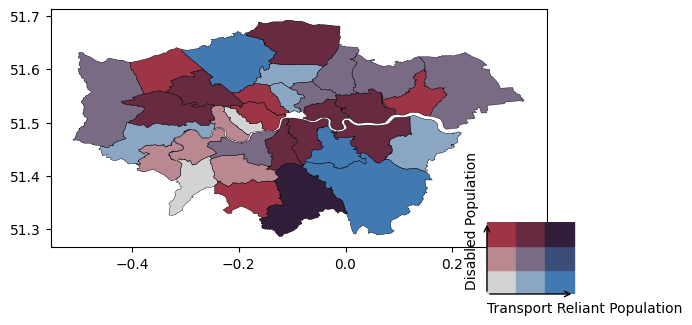

<function print>

In [380]:
london_boroughs = [
    'Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden',
    'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Hammersmith and Fulham',
    'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
    'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham',
    'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark',
    'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'
]

merged_geo_data_london = merged_geo_data[merged_geo_data['Local Authority'].isin(london_boroughs)]
geo_df_london = geo_df[geo_df['LAD13NM'].isin(london_boroughs)]


fig, ax = plt.subplots(1, 1)
merged_geo_data_london.plot(ax=ax, color=colors)




color_sets = {
    'blue-red': [
        # Top row (from left to right)
        '#d3d3d3',  # blue (top left)
        '#ba8890',  # light purple (more blue) (top center)
        '#9e3547',  # purple (top right)

        # Middle row
        '#8aa6c2',  # light blue (middle left)
        '#7a6b84',  # light purple (middle center)
        '#682a41',  # light purple (more blue) (middle right)

        # Bottom row
        '#4279b0',  # light purple (bottom left)
        '#3a4e78',  # light red (bottom center)
        '#311e3b',  # red (bottom right)
    ]
}

#Define your color set
cmap = plt.cm.get_cmap('RdBu')

color_set = color_sets['blue-red']


# Normalize the data
transport_norm = ((merged_geo_data_london['Transport_reliant_population'] - merged_geo_data_london['Transport_reliant_population'].min()) / (merged_geo_data_london['Transport_reliant_population'].max() - merged_geo_data_london['Transport_reliant_population'].min()) * 8).astype(int)
disabled_norm = ((merged_geo_data_london['Disable_population'] - merged_geo_data_london['Disable_population'].min()) / (merged_geo_data_london['Disable_population'].max() - merged_geo_data_london['Disable_population'].min()) * 8).astype(int)

# Calculate colors for each area
colors = [color_set[max(transport_norm.iloc[i], disabled_norm.iloc[i])] for i in range(len(merged_geo_data_london))]

# Plot the geometry
merged_geo_data_london['geometry'].plot(ax=ax, color=colors)

# Add legend
ax2 = fig.add_axes([0.8, 0.15, 0.15, 0.15])
for i in range(3):
    for j in range(3):
        ax2.axvspan(xmin=i/3, xmax=(i+1)/3, ymin=j/3, ymax=(j+1)/3, alpha=1, color=color_set[i*3+j])

ax2.tick_params(axis='both', which='both', length=0)
ax2.axis('off')
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.text(s='Transport Reliant Population', x=0, y=-0.25)
ax2.text(s='Disabled Population', x=-0.25, y=0.1, rotation=90)
legend = ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

merged_geo_data_london.boundary.plot(ax=ax, edgecolor='black', linewidth=0.25)




# Show the plot
plt.show()

print


# Disability and deprivation

In [381]:
#add deprivation and total population data
url = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/BlueBadge/Deprivation_per_borough.csv'
imd_df = pd.read_csv(url, delimiter=',')
imd_df.columns = imd_df.columns.str.strip()
imd_score = imd_df[['Local Authority District name (2019)', 'IMD - Average score']].copy()

merged_geo_data_imd_london= pd.merge(merged_geo_data_london, imd_score, left_on='Local Authority', right_on='Local Authority District name (2019)', how='inner')





In [382]:
url = 'https://raw.githubusercontent.com/bofeng2268/qm2/main/BlueBadge/London%20Borough%20Population%20Final%20.csv'
pop_df = pd.read_csv(url, delimiter=',')
pop_df.columns = pop_df.columns.str.strip()

# Print column names to find the correct one
print(pop_df.columns)



Index(['London Borough', 'Population', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4'],
      dtype='object')


In [383]:

# Adjust the column names in the merge operation
merged_geo_data_imd_pop_london = pd.merge(merged_geo_data_imd_london, pop_df, left_on='Local Authority', right_on='London Borough', how='inner')


merged_geo_data_imd_pop_london.drop(['Local Authority District name (2019)', 'London Borough', 'Unnamed: 2', 'Unnamed: 3','Unnamed: 4' ], axis=1, inplace=True)
# Replace apostrophes and convert to integers
merged_geo_data_imd_pop_london['Population'] = merged_geo_data_imd_pop_london['Population'].str.replace("'", "").astype(int)

merged_geo_data_imd_pop_london['Population'] = pd.to_numeric(merged_geo_data_imd_pop_london['Population'], errors='coerce')


In [384]:
merged_geo_data_imd_pop_london['Population'] = pd.to_numeric(merged_geo_data_imd_pop_london['Population'], errors='coerce')

# Create new column 'Blue_badges_density'
merged_geo_data_imd_pop_london['Blue_badges_density'] = merged_geo_data_imd_pop_london['Blue_Badges_population'] / merged_geo_data_imd_pop_london['Population']

# Create new column 'Transport_reliant_density'
merged_geo_data_imd_pop_london['Transport_reliant_density'] = merged_geo_data_imd_pop_london['Transport_reliant_population'] / merged_geo_data_imd_pop_london['Population']

merged_geo_data_imd_pop_london

,Local Authority,Blue_Badges_population,Disable_population,Transport_reliant_population,geometry,IMD - Average score,Population,Blue_badges_density,Transport_reliant_density
0,Camden,6495.0,31882,25387.0,"POLYGON ((-0.14274 51.56914, -0.14028 51.56438...",20.1,218049,0.029787,0.116428
1,Hackney,6534.0,37020,30486.0,"POLYGON ((-0.06092 51.57806, -0.05846 51.57270...",32.5,261491,0.024987,0.116585
2,Hammersmith and Fulham,4131.0,22972,18841.0,"POLYGON ((-0.22865 51.53048, -0.22865 51.52989...",22.3,185238,0.022301,0.101712
3,Haringey,8230.0,36114,27884.0,"POLYGON ((-0.04128 51.60541, -0.04373 51.60303...",28.0,261811,0.031435,0.106504
4,Islington,7730.0,35063,27333.0,"POLYGON ((-0.10428 51.56497, -0.09856 51.56081...",27.5,220373,0.035077,0.124031
5,Kensington and Chelsea,2442.0,18311,15869.0,"POLYGON ((-0.21638 51.52810, -0.21556 51.52691...",21.5,146154,0.016708,0.108577
6,Lambeth,6202.0,42017,35815.0,"POLYGON ((-0.10919 51.50848, -0.10837 51.50669...",25.4,316812,0.019576,0.113048
7,Lewisham,6698.0,43248,36550.0,"POLYGON ((-0.03228 51.49302, -0.02901 51.48826...",26.7,298653,0.022427,0.122383
8,Newham,9019.0,42032,33013.0,"POLYGON ((0.06836 51.54416, 0.06673 51.54059, ...",29.6,358645,0.025147,0.092049
9,Southwark,6720.0,42022,35302.0,"POLYGON ((-0.03228 51.49302, -0.03719 51.49242...",25.8,311913,0.021544,0.113179


## Regressions: Blue Badges Density VS Deprivation Index

In [385]:
#SUMMARY STATISTICS
summary=merged_geo_data_imd_pop_london.describe().round(2)  # generate summary statistics, and round everything to 2 decimal degrees
summary=summary.T #.T transposes the table (rows become columns and vice versa)
summary


,count,mean,std,min,25%,50%,75%,max
Blue_Badges_population,32.0,8076.88,2798.59,2442.00,6524.25,7405.50,9879.25,15231.00
Disable_population,32.0,36360.47,8389.73,18311.00,30847.00,37021.00,42018.25,54852.00
Transport_reliant_population,32.0,28283.59,6504.27,15869.00,23052.25,28210.50,33577.00,42952.00
IMD - Average score,32.0,21.50,6.06,9.40,16.53,21.90,25.80,32.80
Population,32.0,276729.16,64758.70,146154.00,219506.25,283187.50,326147.75,392224.00
Blue_badges_density,32.0,0.03,0.01,0.02,0.02,0.03,0.03,0.04
Transport_reliant_density,32.0,0.10,0.01,0.08,0.09,0.10,0.11,0.12


Text(0.5, 1.0, 'Density of blue badges held per total borough population VS IMD - Average score per borough (London, 2022)')

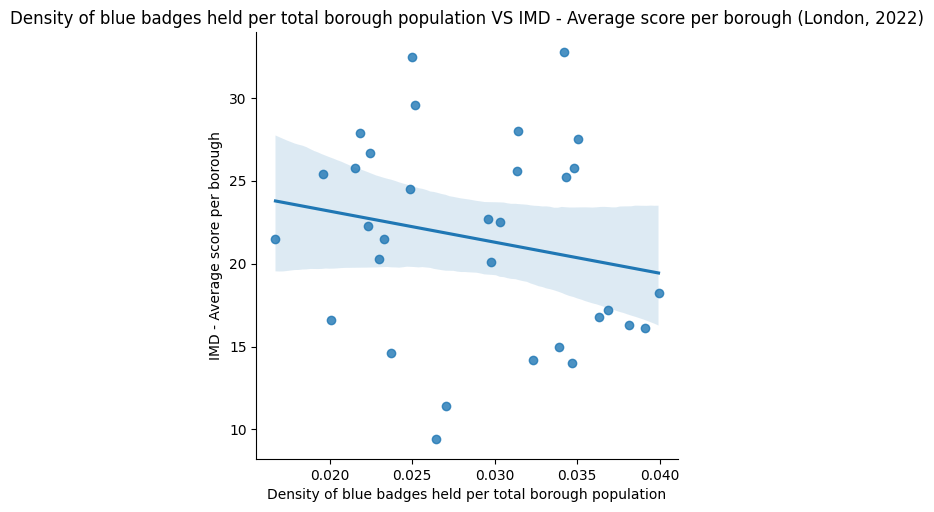

In [386]:
#SCATTERPLOT
# Generate the scatter plot
sns.lmplot(x='Blue_badges_density', y='IMD - Average score', data= merged_geo_data_imd_pop_london)

plt.xlabel('Density of blue badges held per total borough population')
plt.ylabel('IMD - Average score per borough')

# Display the plot
plt.title("Density of blue badges held per total borough population VS IMD - Average score per borough (London, 2022)")


Text(87.72222222222221, 0.5, 'IMD - Average score per borough')

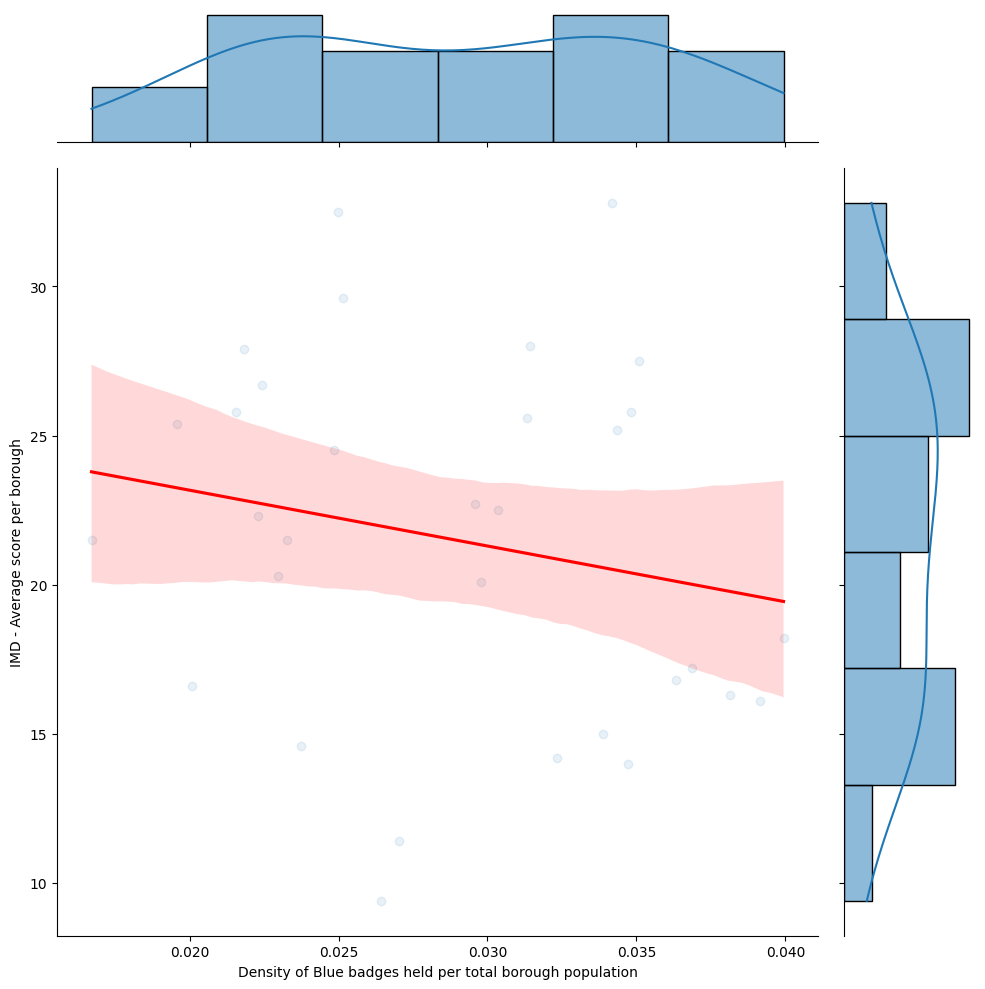

In [387]:
def homoscedasticity_test(lm_results):
    print(lm_results.summary())

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(lm_results.resid, lm_results.model.exog)

    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    print("\nBreusch-Pagan test for homoscedasticity:")
    homoscedasticity = False
    for label, value in zip(labels, bp_test):
        print(f"{label}: {value}")
        if label == "F-Test p-value":
            if value > 0.05:
                homoscedasticity = True
    if homoscedasticity:
        print("The regression convey homoscedasticity")
    else:
        print("The regression does not convey homoscedasticity")


#Homoscedasticity
sns.jointplot(data=merged_geo_data_imd_pop_london, # plot a scatterplot with a regression line and two histograms
                x='Blue_badges_density', # set the x axis to be the years of schooling
                y='IMD - Average score', # set the y axis to be the hourly wage
                kind="reg",  # set the kind of plot to be a regression plot
                scatter_kws=dict(alpha=0.1), # set the transparency of the points to be 0.1 (10%)
                line_kws=dict(color='red'), # set the color of the regression line to red
                height=10) # set the height of the plot to be 10 inches

plt.xlabel('Density of Blue badges held per total borough population') # add a label to the x axis
plt.ylabel('IMD - Average score per borough') # add a label to the y axis


In [388]:
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

# Note the use of `Q()` around the column name with a hyphen
model = ols('Blue_badges_density ~ Q("IMD - Average score")', data=merged_geo_data_imd_pop_london).fit()
print(model.summary())

import statsmodels.formula.api as smf
from scipy import stats

# Again, use `Q()` for the column name
lm_results_1 = smf.ols('Blue_badges_density ~ Q("IMD - Average score")', data=merged_geo_data_imd_pop_london).fit()

# Assuming you have a function defined for homoscedasticity_test
homoscedasticity_test(lm_results_1)


                             OLS Regression Results                            
Dep. Variable:     Blue_badges_density   R-squared:                       0.040
Model:                             OLS   Adj. R-squared:                  0.008
Method:                  Least Squares   F-statistic:                     1.249
Date:                 Mon, 15 Jan 2024   Prob (F-statistic):              0.273
Time:                         16:24:34   Log-Likelihood:                 117.03
No. Observations:                   32   AIC:                            -230.1
Df Residuals:                       30   BIC:                            -227.1
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept     

In [389]:

from tabulate import tabulate

# Assign the actual LM test results to variables
lm_statistic = 4.947847597611243
lm_pvalue = 0.02612317219835892

# Define the data for the table
bp_lm_test_data = [
    ["Test Statistic", lm_statistic],
    ["p-value", lm_pvalue]
]

# Create the table using tabulate
bp_lm_test_table = tabulate(bp_lm_test_data, headers=["Test", "Value"], tablefmt="pretty")

# Print the table
print("Results of the Breusch-Pagan LM Test")
print(bp_lm_test_table)

Results of the Breusch-Pagan LM Test
+----------------+---------------------+
|      Test      |        Value        |
+----------------+---------------------+
| Test Statistic |  4.947847597611243  |
|    p-value     | 0.02612317219835892 |
+----------------+---------------------+


<ipython-input-390-7382931d7b20>:30: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



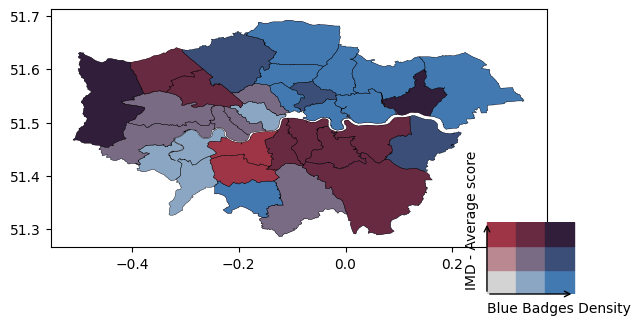

<function print>

In [390]:
#VISUALISATION

fig, ax = plt.subplots(1, 1)
merged_geo_data_imd_pop_london.plot(ax=ax, color=colors)

model = ols('Blue_badges_density ~ Q("IMD - Average score")', data=merged_geo_data_imd_pop_london).fit()



color_sets = {
    'blue-red': [
        # Top row (from left to right)
        '#d3d3d3',  # blue (top left)
        '#ba8890',  # light purple (more blue) (top center)
        '#9e3547',  # purple (top right)

        # Middle row
        '#8aa6c2',  # light blue (middle left)
        '#7a6b84',  # light purple (middle center)
        '#682a41',  # light purple (more blue) (middle right)

        # Bottom row
        '#4279b0',  # light purple (bottom left)
        '#3a4e78',  # light red (bottom center)
        '#311e3b',  # red (bottom right)
    ]
}

#Define your color set
cmap = plt.cm.get_cmap('RdBu')

color_set = color_sets['blue-red']


# Normalize the data
transport_norm = ((merged_geo_data_imd_pop_london['Blue_badges_density'] - merged_geo_data_imd_pop_london['Blue_badges_density'].min()) / (merged_geo_data_imd_pop_london['Blue_badges_density'].max() - merged_geo_data_imd_pop_london['Blue_badges_density'].min()) * 8).astype(int)
disabled_norm = ((merged_geo_data_imd_pop_london['IMD - Average score'] - merged_geo_data_imd_pop_london['IMD - Average score'].min()) / (merged_geo_data_imd_pop_london['IMD - Average score'].max() - merged_geo_data_imd_pop_london['IMD - Average score'].min()) * 8).astype(int)

# Calculate colors for each area
colors = [color_set[max(transport_norm.iloc[i], disabled_norm.iloc[i])] for i in range(len(merged_geo_data_imd_pop_london))]

# Plot the geometry
merged_geo_data_imd_pop_london['geometry'].plot(ax=ax, color=colors)

# Add legend
ax2 = fig.add_axes([0.8, 0.15, 0.15, 0.15])
for i in range(3):
    for j in range(3):
        ax2.axvspan(xmin=i/3, xmax=(i+1)/3, ymin=j/3, ymax=(j+1)/3, alpha=1, color=color_set[i*3+j])

ax2.tick_params(axis='both', which='both', length=0)
ax2.axis('off')
ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))
ax2.text(s='Blue Badges Density', x=0, y=-0.25)
ax2.text(s='IMD - Average score', x=-0.25, y=0.1, rotation=90)
legend = ax.legend(loc='lower left', bbox_to_anchor=(1, 0))

merged_geo_data_imd_pop_london.boundary.plot(ax=ax, edgecolor='black', linewidth=0.25)




# Show the plot
plt.show()

print


##Regressions: Blue Badges Density VS Deprivation Index

# NEXT STEPS (to do by Saturday 13th night - so we have time to do analysis)
- Bivariate choropleth Map: Transport Reliant VS Disable_population
- add Deprivation Factor (https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019) variable OR loneliness (Data for loneliness:  
https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/disability/datasets/disabilityandloneliness)
  - repeat all process done so far
  - do Trivariant choropleth map / or Bubble Map: add deprivation factor as bubbles on the Bivariate choropleth map
- for all models: regression diagnostics
  - multi collinearity
  - normality
  - homoscedasticity
- Geographic weighted regression: Reference: https://deepnote.com/@carlos-mendez/PYTHON-GWR-and-MGWR-71dd8ba9-a3ea-4d28-9b20-41cc8a282b7a
  - regression

- extra: london voronoi diagrams (if we have time)

